# CV Exercise 2 – Feature extraction and matching

## Overview

This practical exercise complements Lectures 05 on feature extraction and matching.

It covers the topics of detecting and describing image features and
matching pairs of keypoints to find correspondences between images or
image parts. The found correspondences can then be used to e.g. stitch
two images together (panorama images).

In this assignment you will write code for the three main parts needed
for such approaches, i.e. keypoint detection, keypoint description and keypoint matching.

You can use the notebook to visualize the results of different methods for the
application of image stitching. Furthermore, we provide SIFT/Stupid
keypoints and SIFT descriptors as reference implementations.

**You will learn:**

-   Feature detection using Harris Corner Detection.

-   Feature description (a simple 25x25 window vs. MOPS using
    orientation).

-   Feature matching (SSD and ratio).

-   Advantages and drawbacks of different combinations.

**Your tasks**

We will start with the last sxtep in the pipeline, i.e. the Keypoint matching strategies (i.e. the distance computation between the feature descriptors). For this you can use the reference implementations from OpenCV (SIFT keypoints and descriptors). Having this last module at hand will make it easier for you to develop evaluated your own modifications in the pipeline, i.e. your own keypoint detectors (step 2: Harris corner detector) and descriptors (step 3-4: Simple and Simple MOPS). 

1.  Implement feature matching using SSD and the Ratio Distance.

2.  Implement the most important code parts for Harris corner detection.

3.  Implement a simple 25x25 feature descriptor.

4.  Implement the MOPS (Multi-Scale Oriented Patches) Descriptor which makes additional use of the keypoint orientation.

5.  Being able to answer some questions.

The following additional resources might come in handy:
- [OpenCV documentation](https://docs.opencv.org/4.x/)
- [Numpy documentation](https://numpy.org/doc/)

If you have questions, please contact either Prof. Fabian Flohr ([fabian.flohr@hm.edu](mailto:fabian.flohr@hm.edu)).



Execute the following cell to import some modules and set some preferences.

In [151]:
%load_ext autoreload
%autoreload

import math
import copy
import numpy as np
import cv2
###########################################
import scipy.ndimage
import scipy.spatial
###########################################
from scipy import spatial, ndimage
import matplotlib.pyplot as pyplot
%matplotlib inline

from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




## Step 1: Implementation of Matching strategies

We start at the end of the pipeline: The matching strategies. By starting at the end it is easier to evaluate your implementations for the keypoint detector and descriptors. 
The Matching compares the keypoints and their description with each other. Luckily, we can just measure distances between them, since we have vectors with real numbers. You will implement two different ways of distances (also discussed in the lecture):

1.  Sum of squared differences (SSD): Euclidean distance between each
    pair of keypoints. For a keypoint in the first image choose the best
    matching keypoint (minimum distance) in the second image. Accept the
    top 100 matches (after sorting the list, see below). The num of matches should be provided by parameter.
    (fill **TODO-1** block in the function ```match_features``` of class
    ```SSDKeypointMatcher``` in the code below)

2.  Nearest Neighbor Distance Ratio: Find the best and the second best
    SSD match. Compute the ratio between them (SSD1/SSD2) and use this ratio
    as matching score. Accept all ratios which are lower than 0.8. Check
    the publication of Lowe for details (3) on this threshold.
    (fill **TODO-2** block in the function *match_features* of class
    ```RatioKeypointMatcher``` in the code below)

The implemented functions should return a list of ```cv2.DMatch objects```. Set
the ```queryIdx``` attribute of the ```cv2.DMatch``` objects to the index of the
feature in the first image, the ```trainIdx``` attribute to the index of the
feature in the second image. The ```distance``` attribute should then
contain your computed distance between the two keypoints (e.g., SSD or
Ratio). The returned list should be sorted in ascending order and
thresholded on the distance attribute.

You could make use of the following additional functions  
(but again: there are different ways to do that):

-   ```scipy.spatial.distance.cdist```

-   ```numpy.argmin```

In the next cell, start with the SSD Matcher and test your implementation, then continue with the Ratio Matcher.

In [152]:
#############################
## Feature matchers #########
#############################

class SSDKeypointMatcher(AbstractKeypointMatcher):
    # Performs simple feature matching.  This uses the SSD
    # distance between two feature vectors, and matches a feature in
    # the first image with the closest feature in the second image.
    # Note: multiple features from the first image may match the same
    # feature in the second image.

    def match_features(self, desc1, desc2, num_matches=-1):
        '''
        Input:
            desc1 -- feature descriptors of image 1 stored in a numpy array,
                dimensions: rows (number of key points) x
                columns (dimension of the feature descriptor)
            desc2 -- feature descriptors of image 2 stored in a numpy array,
                dimensions: rows (number of key points) x
                columns (dimension of the feature descriptor)
            num_matches -- Number of matches; Hard requirement to return not more than this number;
                num_matches=-1: return all matches
        Output:
            features matches: a list of cv2.DMatch objects
                How to set attributes:
                    queryIdx: The index of the feature in the first image
                    trainIdx: The index of the feature in the second image
                    distance: The distance between the two features
        '''
        matches = []
        # feature count = n
        assert desc1.ndim == 2
        # feature count = m
        assert desc2.ndim == 2
        # the two features should have the type (? i.e same number of columns ?)
        assert desc1.shape[1] == desc2.shape[1]

        if desc1.shape[0] == 0 or desc2.shape[0] == 0:
            return []
        
        # TODO-1: Perform euclidean matching.
        # This uses the SSD distance and matches a feature 
        # in the first image with the closest feature in the second image.
        # Note: multiple features from the first image may match the same
        # feature in the second image.
        # Choose the 100 best matches (if available, otherwise len(matches)).
        # TODO-BLOCK-BEGIN
        # Euclidean distance between all keypoint pairs
       
        for i in range(desc1.shape[0]):
            
            #calculate the distance between every jth element for the specified i
            distances = np.linalg.norm(desc1[i, :] - desc2, axis = 1);
            j = np.argmin(distances);
            
            #create a new match object for every new j or i hence inside the loop
            match = cv2.DMatch();
            match.queryIdx = i;
            match.trainIdx = j;
            match.distance = distances[j];
                
            #store the dmatch object match in a list matches
            matches.append(match);
        
        matches.sort(key = lambda x: x.distance)
            
        
        if num_matches != -1:
            matches = matches[:min(num_matches, 100)]
        else:
            matches = matches[:100]
            
        #replace
        return matches

        # TODO-BLOCK-END



class RatioKeypointMatcher(AbstractKeypointMatcher):
    def match_features(self, desc1, desc2, num_matches=-1):
        '''
        Input:
            desc1 -- feature descriptors of image 1 stored in a numpy array,
                dimensions: rows (number of key points) x
                columns (dimension of the feature descriptor)
            desc2 -- feature descriptors of image 2 stored in a numpy array,
                dimensions: rows (number of key points) x
                columns (dimension of the feature descriptor)
            num_matches -- Number of matches; Hard requirement to return not more than this number;
                num_matches=-1: return all matches
        Output:
            features matches: a list of cv2.DMatch objects
                How to set attributes:
                    queryIdx: The index of the feature in the first image
                    trainIdx: The index of the feature in the second image
                    distance: The distance between the two features
        '''
        matches = []
        # feature count = n
        assert desc1.ndim == 2
        # feature count = m
        assert desc2.ndim == 2
        # the two features should have the type
        assert desc1.shape[1] == desc2.shape[1]

        if desc1.shape[0] == 0 or desc2.shape[0] == 0:
            return []

        # TODO-2: Perform ratio feature matching.
        # This uses the ratio of the SSD distance of the two best matches
        # and matches a feature in the first image with the closest feature in the
        # second image.
        # Note: multiple features from the first image may match the same
        # feature in the second image.
        # Select the matches with a ratio<0.8 (see Loewe paper)
        # TODO-BLOCK-BEGIN
       
        for i in range(desc1.shape[0]):
            
            #find the distance between ith key point descriptor and every jth keypoint descriptor
            #and store it in match an indiced dmatch object
            distances = np.linalg.norm(desc1[i, :] - desc2, axis = 1);
            j = np.argmin(distances);
            qIdx = i;
            tIdx = j;
            
            #store the minimum distance as ssd1
            ssd1 = distances[j];
            
            #remove the minimum value 
            distances = np.delete(distances, j);
            
            #find the new minimum value that is actually the second minimum value and store it in ssd2
            j = np.argmin(distances);
            ssd2 = distances[j];
            
            #find the distance ratio value
            ratio = ssd1/ssd2;
            
            if ratio < 0.8:
                match = cv2.DMatch();
                match.distance = ratio;
                match.queryIdx = qIdx;
                match.trainIdx = tIdx;

                #store the dmatch object match in a list matches
                matches.append(match); 

        matches.sort(key = lambda x: x.distance)
        
        if num_matches != -1:
            matches = matches[:min(num_matches, 100)]
        else:
            matches = matches[:100]

        #replace
        return matches


        # TODO-BLOCK-END

In the following you can test your implementation of the matchers with the given reference implementations of SIFT (Detector and Descriptor). Those reference implementations will be replaced by your own implementation in the following steps. For you can use them to understand the pipeline and the expected outcome of the matching process.

INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing matches ...
INFO:Exercise 2 Logging:Estimating Homography...
INFO:Exercise 2 Logging:Estimated Homography: [[ 3.45912210e-01  5.03556658e-01  1.96195224e+02]
 [-1.34321919e-01  1.01203983e+00  1.33158968e+01]
 [-1.81201856e-03  1.30123679e-03  1.00000000e+00]]


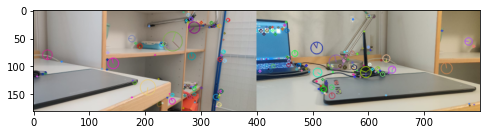

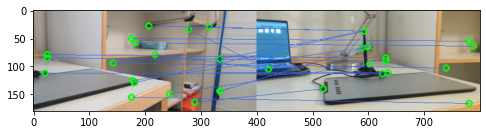

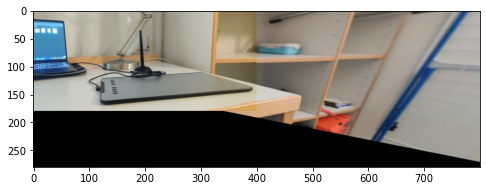

In [203]:
IMG_PAIRS = "rome" # possible values: "checkboard", "dom", "dom_rot", "rose", "castle"

# reference detector: SIFT Keypoint Extractor (for now)
DETECTOR = SIFTKeypointDetector() # possible values: "StupidKeypointDetector", "SIFTKeypointDetector", "HarrisKeypointDetector"

# reference detector: SIFT Keypoint Descriptor (for now)
DESCRIPTOR = SIFTKeypointDescriptor() # possible values: "SimpleKeypointDescriptor", "MOPSKeypointDescriptor", "SIFTKeypointDescriptor"

# The matches needs to implemented by you. Start with the SSD Matcher above.
MATCHER = RatioKeypointMatcher() # possible values: SSDKeypointMatcher(), RatioKeypointMatcher()

#loade images
image_arr = load_image_pairs(IMG_PAIRS)
keypoints_arr = []

#compute keypoints for each image 
for img in image_arr:
    keypoints = compute_keypoints(img, DETECTOR)
    keypoints_arr.append(keypoints)

vis_keyp = vis_keypoints(copy.deepcopy(image_arr),keypoints_arr)

#visualize keypoints
pyplot.rcParams["figure.figsize"] = [8, 8]
pyplot.figure()
pyplot.imshow(vis_keyp)

# descripe the keypoints with a descriptor vector
descriptors_arr = describe_keypoints(image_arr, keypoints_arr, DESCRIPTOR)

# match the descriptor vectors and compute a distance;
matches = compute_matches(descriptors_arr, MATCHER, num_matches=100)

if matches:

    # visualize matches
    vis_mat = vis_matches(copy.deepcopy(image_arr),keypoints_arr,matches)
    pyplot.figure()
    pyplot.imshow(vis_mat)

    # compute the homography based on the matches
    M = compute_homography(keypoints_arr,matches)

    # visualizes final stitching with homograhpy drawn in
    vis_stit = vis_stitch(copy.deepcopy(image_arr), M) 
    pyplot.figure()
    pyplot.imshow(vis_stit)
else:
    logger.error("No matches to visualize")

# ## Step 2: Implementation of Harris Corner Detection

In this task you have to implement the core of the Harris Corner
Detector, i.e. extracting the R-values from the image and threshold them to get good keypoint
locations. (fill **TODO-3** block in function *compute_harris_values* in the below code)

You need to compute the R values for each pixel in the image according
to (or alternative ways discussed in lecture):

<img src="./media/image1.png" width="300">

The necessary matrix **M** is given by:

<img src="./media/image2.png" width="400">

Where the entries of the 2x2 M-matrix are computed based on the
horizontal and vertical image gradients ($I_{x}$ and $I_{y}$). You could
use a 3x3 Sobel image filter for that.

The gradients are summed up over a local window with a Gaussian
smoothing. You could start using a 5x5 Gaussian mask with a sigma=5 for
that, but you should urgently play around with the parameters here.

Furthermore, you need to extract the keypoint orientation. This one can
be calculated for each image location using the ```arctan2``` function with
the vertical and horizontal gradients as input.


You can **neglect** **different scale spaces** (since our image pairs are
roughly in the same scale space).

At the end you need to fill a ```cv2.KeyPoint()``` object for each keypoint.
Save one object per keypoint in a list. This is your return value. (See
also SIFT/Stupid detector reference).

( fill **TODO-4** block in function ```detect_keypoints``` in the below code)*

To optimize keypoint response, you need to perform a local maximum
suppression in the local neighborhood. 

( fill **TODO-5** block in function ```compute_local_maxima``` in the below code)

You could make use of the following function (but you can also choose
other libraries/functions):

-   ```cv2.Sobel```
    Filters the input image with Sobel filter.

-   ```cv2.GaussianBlur``` 
    Filters the input image with a Gaussian filter.

-   ```scipy.ndimage.filters.maximum_filter```
    Filters the input image with a local maximum filter defined on a
    given neighborhood

> For details look in the documentation of those functions.

> Check the publication of Harris and Stephans for details (1).



In [204]:

#############################
## Keypoint detectors #######
#############################

class HarrisKeypointDetector(AbstractKeypointDetector):

    def cart_to_polar_and_binned(self, dx, dy, num_bins=32):
        '''
        Helper function to compute angles + bins from derviatives. 
        You might use this function for an easier mean angle computation.
        Input:
            (dx,dy) -- horizontal and vertical image gradients
            (num_bins) -- number of bins for angle disretization
        Output:
            (mag) -- magnitude of image gradient
            (theta) -- angle of image gradients
            (bin_theta) -- binned angle of image gradients.
        '''
        mag = np.sqrt(dx**2 + dy**2) 
        theta = (np.arctan2(dy, dx)+np.pi) #* 180/np.pi
        bin_width = 360/num_bins 
        bin_theta = np.int8(np.floor(theta)/bin_width)
        return mag, theta, bin_theta

    # Compute harris values of an image.
    # You are allowed to change the signature of the method to allow additional inputs (e.g. parameters)
    def compute_harris_values(self, image):
        '''
        Harris Corner Detection (input scale space only)
        Input:
            image -- BGR image with values between [0, 255]
            TODO: Name additional used parameters here.
            additional parameters: k_size sigma
        Output:
            (harris_response) -- 2d array containing R-values (size of image).
            (harris_angle) -- 2d array containing orientation values (size of image).
        '''
        # init some variables 
        y_range = image.shape[0]
        x_range = image.shape[1]
        harris_response = np.zeros((y_range,x_range), np.float32)
        harris_angle = np.zeros((y_range,x_range), np.float32)
        
        k_size = 5;
        sigma  = 3;
        k = 0.05;
        
        # TODO-3: Implement the Harris Corner detection. 
        # Ignore different scale spaces for easier implementation.
        # TODO-BLOCK-BEGIN
        
        ##############################Calculation M=[S_x2 S_xy];[S_xy S_y2]########################################
        #Prepare the image apply blur and convert image to grayscale
        image_blur = cv2.GaussianBlur(image, (3,3),0,0);
        
        #Compute vertical and horizontal derivative using vertical and horizontal 3x3 sobel filters
        #calculate I_x and I_y
        I_x = cv2.Sobel(image_blur, -1, 1, 0, 3);
        I_x = np.array(I_x);
        I_y = cv2.Sobel(image_blur, -1, 0, 1, 3);
        I_y = np.array(I_y);
        #calculate I_x2, I_y2 and I_xy
        I_x2 = np.multiply(I_x,I_x);
        I_y2 = np.multiply(I_y,I_y);
        I_xy = np.multiply(I_x,I_y);
        
        #convolve 
        gauss  = cv2.getGaussianKernel(k_size, sigma);
        window = np.outer(gauss,gauss);
        S_x = cv2.filter2D(I_x, -1, window);
        S_y = cv2.filter2D(I_y, -1, window);
        S_x2 = cv2.filter2D(I_x2, -1, window);
        S_y2 = cv2.filter2D(I_y2, -1, window);
        S_xy = cv2.filter2D(I_xy, -1, window);
        
    
        ###################################Update harris_response and harris_angle################################
        DetM = np.multiply(S_x2,S_y2) - np.multiply(S_xy,S_xy);
        TraM = S_x2 + S_y2;
        harris_response = DetM - k*np.multiply(TraM,TraM);
        harris_angle    = np.arctan2(I_y,I_x);
        # TODO-BLOCK-END
        
        ###################################Images to debug########################################################
        cv2.imwrite("debug_images\I_x.jpg", I_x);
        cv2.imwrite("debug_images\I_y.jpg", I_y);
        cv2.imwrite("debug_images\I_x2.jpg", I_x2);
        cv2.imwrite("debug_images\I_y2.jpg", I_y2);
        cv2.imwrite("debug_images\I_xy.jpg", I_xy);
        
        cv2.imwrite("debug_images\S_x.jpg", S_x);
        cv2.imwrite("debug_images\S_y.jpg", S_y);
        cv2.imwrite("debug_images\S_x2.jpg", S_x2);
        cv2.imwrite("debug_images\S_y2.jpg", S_y2);
        cv2.imwrite("debug_images\S_xy.jpg", S_xy);
        
        cv2.imwrite("debug_images\harris_response.jpg", harris_response);

        return harris_response, harris_angle 


    # at the moment this function declares all points as local max
    # your task is here to give it a more meaningful implementation 
    # reducing the number of keypoints by a local non-maximum supression
    def compute_local_maxima(self, harrisImage):
        '''
        Input:
            harrisImage -- numpy array containing the Harris score at
                           each pixel.
        Output:
            destImage -- numpy array containing True/False at
                         each pixel, depending on whether
                         the pixel value is the local maxima in
                         its local neighborhood (defined by window_size)
        '''
        window_size = 5
        destImage = np.ones_like(harrisImage, bool)

        # TODO-5: Compute the local maxima image. 
        # Only accept a R-value when it is the highest in the local neighborhood.
        # TODO-BLOCK-BEGIN
        maxFilterImage = scipy.ndimage.filters.maximum_filter(harrisImage, window_size);
        #compare harrisImage with itself_max_filtered
        destImage = (maxFilterImage == harrisImage)
        
#         for i,j in np.ndindex(harrisImage.shape):
#             if maxFilterImage[i][j] == harrisImage[i][j]:
#                 destImage[i][j] = 1;
#             else:
#                 destImage[i][j] = 0;


        # TODO-BLOCK-END
    
    ###################################Images to debug########################################################
        debug_destImage = np.uint8(destImage)*255;
        cv2.imwrite("debug_images\destImg_compute_local_maxima.jpg", debug_destImage);
        cv2.imwrite("debug_images\maxFilterImage.jpg", maxFilterImage);
        
        return destImage

    # main entry function to detect keypoints
    def detect_keypoints(self, image):
        '''
        Input:
            image -- BGR image with values between [0, 255]
        Output:
            list of detected keypoints, fill the cv2.KeyPoint objects with the
            coordinates of the detected keypoints, the angle of the gradient
            (in degrees), the detector response (Harris score for Harris detector)
            and set the size to 10.
        '''

        # List of cv2.KeyPoints (need to stick to this cv2.KeyPoint struct)
        features = []

        # Threshold value (feel free to change). This might be dependent on the image you use.
        # The final threshold_value could be calculated based on the max R value found.
        # i.e. threshold_value = threshold*max_harris_response 
        threshold=0.01 #0.01

        # compute_harris_values() computes the harris score at each pixel
        # position, storing the result in harrisImage.
        # TODO: You will need to implement this function.
        harris_response, harris_angle = self.compute_harris_values(image)

        # compute max response (R value) to set the final threshold_value
        max_harris_response = np.amax(harris_response)
        threshold_value = max_harris_response*threshold

        # compute_local_maxima() computes the local maxima in the Harris image.  
        # TODO: You will need to implement this function. 
        # Create an image to store local maximum harris
        # values as True, other pixels False. Play around with the window_size
        harris_true_max_b = self.compute_local_maxima(harris_response)

        # Loop through feature points in harris_response / harris_angle and fill in information
        # needed for descriptor computation for each point.
        # You need to fill x, y, and angle.
        
        for iy, ix in np.ndindex(harris_response.shape):

            # you can check if we have a real maxima according to 
            if not harris_true_max_b[iy][ix]:
                continue
            if harris_response[iy][ix]<threshold_value:
                continue

            f = cv2.KeyPoint()

            # TODO-4: Fill in feature f with location and orientation
            # data here. Set f.size to 10, f.pt to the (x,y) coordinate, f.pt uses (column,row) representation
            # f.angle = orientation in degrees [0, 360] and f.response = Harris R score
            # TODO-BLOCK-BEGIN
            f.size     = 10;
            f.pt       = (ix, iy);
            f.angle    = harris_angle[iy][ix]*180/np.pi;
            f.response = harris_response[iy][ix];
            features.append(f);
            # TODO-BLOCK-END
        return features

In the following you can now test your implementation of the Harris Corner detector by using basically the same code as before, expect that you will now use your own implementation of  ```HarrisKeypointDetector``` instead of the reference implementation ```SIFTKeypointDetector```. The descriptor stays the same for now. You should still be able to see a more or less correct stitching of the image and the computed homography should be quite close to the one above. What difference do you recognize in the keypoint detection (visualization) and why?

> **Important**: If you have problems with the implementations and check the expected output on the **checkboard image pair** first. Don't expect a correct homography in this case. Why ist this?

INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing matches ...


features extraxted
number of features in image 1: 2030
number of features in image 2: 1919
visualize keypoints done
describe keypoints using SIFT discriptor done


INFO:Exercise 2 Logging:Estimating Homography...
INFO:Exercise 2 Logging:Estimated Homography: [[ 5.70896034e-01 -2.90006941e-02  2.08077447e+02]
 [-9.04588198e-02  8.63061406e-01  1.69960666e+01]
 [-1.07259286e-03 -3.86688348e-05  1.00000000e+00]]


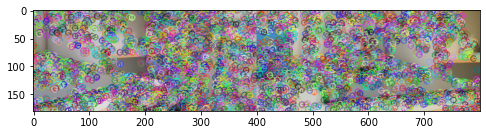

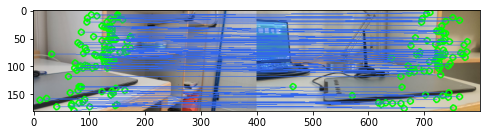

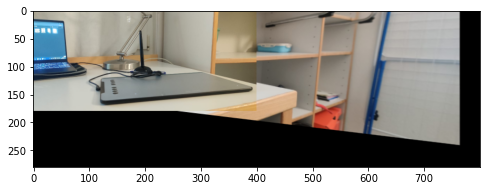

In [205]:
IMG_PAIRS = "rome" # possible values: "checkboard", "dom", "dom_rot", "rose", "castle"

# reference detector: SIFT Keypoint Extractor (for now)
DETECTOR = HarrisKeypointDetector() # possible values: "StupidKeypointDetector", "SIFTKeypointDetector", "HarrisKeypointDetector"

# reference detector: SIFT Keypoint Descriptor (for now)
DESCRIPTOR = SIFTKeypointDescriptor() # possible values: "SimpleKeypointDescriptor", "MOPSKeypointDescriptor", "SIFTKeypointDescriptor"

# The matches needs to implemented by you. Start with the SSD Matcher above.
MATCHER = RatioKeypointMatcher() # possible values: SSDKeypointMatcher(), RatioKeypointMatcher()

#loade images
image_arr = load_image_pairs(IMG_PAIRS)
keypoints_arr = []

#compute keypoints for each image 
for img in image_arr:
    keypoints = compute_keypoints(img, DETECTOR)
    keypoints_arr.append(keypoints)

vis_keyp = vis_keypoints(copy.deepcopy(image_arr),keypoints_arr)

####################################################################################################
print("features extraxted");
print("number of features in image 1:", len(keypoints_arr[0]));
print("number of features in image 2:", len(keypoints_arr[1]));
####################################################################################################

#visualize keypoints
pyplot.rcParams["figure.figsize"] = [8, 8]
pyplot.figure()
pyplot.imshow(vis_keyp)

####################################################################################################
print("visualize keypoints done");
####################################################################################################

# descripe the keypoints with a descriptor vector
descriptors_arr = describe_keypoints(image_arr, keypoints_arr, DESCRIPTOR)

####################################################################################################
print("describe keypoints using SIFT discriptor done");
####################################################################################################

# match the descriptor vectors and compute a distance;
matches = compute_matches(descriptors_arr, MATCHER, num_matches=100)

if matches:

    # visualize matches
    vis_mat = vis_matches(copy.deepcopy(image_arr),keypoints_arr,matches)
    pyplot.figure()
    pyplot.imshow(vis_mat)

    # compute the homography based on the matches
    M = compute_homography(keypoints_arr,matches)

    # visualizes final stitching with homograhpy drawn in
    vis_stit = vis_stitch(copy.deepcopy(image_arr), M) 
    pyplot.figure()
    pyplot.imshow(vis_stit)
else:
    logger.error("No matches to visualize")



## Step 3: Implementation of the Simple keypoint descriptor

In this part you will implement a first very simple keypoint descriptor,
which serves later for comparing two different keypoints and measure a
distance between them.

( fill **TODO-6** block in the function ```describe_features``` of class
```SimpleKeypointDescriptor``` in the below code.)

Remember our lecture again, where we discussed a simple but effective
implementation. This simple descriptor takes just the raw pixels in a 5x5 window around
each keypoint position. This leaves us finally with a 1x25 dim feature
descriptor vector per keypoint.



In [206]:
#############################
## Keypoint descriptors ######
#############################
class SimpleKeypointDescriptor(AbstractKeypointDescriptor):
    # TODO: Implement parts of this function
    def describe_features(self, image, keypoints):
        '''
        Input:
            image -- gray image with values between [0, 255]
            keypoints -- the detected features, we have to compute the feature
                         descriptors at the specified coordinates
        Output:
            desc -- #keypoint x 25 numpy array
        '''
        # our descriptor is a 5x5 patch, i.e. 25 dimenstions
        desc = np.zeros((len(keypoints), 5 * 5)) #5x5

        height, width = image.shape[:2] #RGB .shape() gives (rows,cols, 3) 3 for the R,G and B
        print("image shape:",image.shape)

        # loop over all keypoints and compute descriptor for each keypoint
        for i, f in enumerate(keypoints):
#             if i>=10:
#                 break;

            # keypoint location
            keyp_x, keyp_y = int(f.pt[0]), int(f.pt[1])

            # TODO-6: The simple descriptor is a 5x5 window of intensities
            # sampled centered on the feature point. Store the descriptor
            # as a row-major vector i.e row1 gives descriptor for keypoint1. Treat pixels outside the image as zero.
            # Ignore scale space and orientation.
            # TODO-BLOCK-BEGIN
            #patch to append
            patch = np.zeros((5,5));#5x5
            for u,v in np.ndindex(patch.shape):
                ix = keyp_y+(u-2);#-2
                iy = keyp_x+(v-2);
                
                if ix<0 or iy<0 or iy>(width-1) or ix>(height - 1):
                    continue;
                    
                patch[u][v] = image[ix][iy];
                
#             for u,v in np.ndindex((10,10)):
#                 ix = 50+(u-5);
#                 iy = 50+(v-5);
#                 patch[ix][iy]=255;
                
#             cv2.imwrite(f"debug_images\patch{i}.jpg",patch);
                
            desc[i] = patch.flatten();
           
            # TODO-BLOCK-END
#         print(desc)

        return desc



In the following you can now test your implementation of Simple descriptor by using basically the same code as before, expect that you will now use your own implementation of  ```SimpleKeypointDescriptor``` instead of the reference implementation ```SIFTKeypointDescriptor```. You should still be able to see a more or less correct stitching of the image and the computed homography should be still close to the one above. 

INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Image shape: (576, 1280, 3)
INFO:Exercise 2 Logging:New image dim: (400, 180)
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...
INFO:Exercise 2 Logging:Computing keypoint descriptors ...


image shape: (180, 400)
image shape: (180, 400)


INFO:Exercise 2 Logging:Computing matches ...
INFO:Exercise 2 Logging:Estimating Homography...
INFO:Exercise 2 Logging:Estimated Homography: [[-1.36667164e+00  1.13674517e+00  2.38931747e+02]
 [-4.06463376e-01  3.84668467e-01  2.89383797e+01]
 [-7.15431989e-03  4.52866139e-03  1.00000000e+00]]


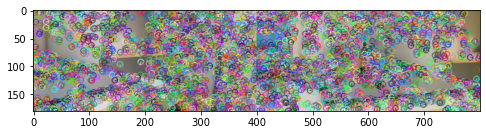

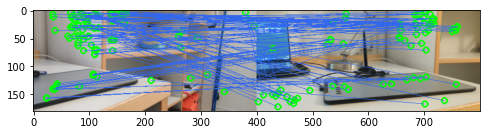

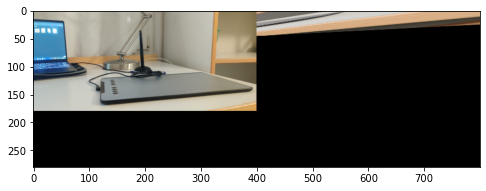

In [209]:
IMG_PAIRS = "rome" # possible values: "checkboard", "dom", "dom_rot", "rose", "castle"

# reference detector: SIFT Keypoint Extractor (for now)
DETECTOR = HarrisKeypointDetector() # possible values: "StupidKeypointDetector", "SIFTKeypointDetector", "HarrisKeypointDetector"

# reference detector: SIFT Keypoint Descriptor (for now)
DESCRIPTOR = SimpleKeypointDescriptor() # possible values: "SimpleKeypointDescriptor", "MOPSKeypointDescriptor", "SIFTKeypointDescriptor"

# The matches needs to implemented by you. Start with the SSD Matcher above.
MATCHER = SSDKeypointMatcher() # possible values: SSDKeypointMatcher(), RatioKeypointMatcher()

#loade images
image_arr = load_image_pairs(IMG_PAIRS)
keypoints_arr = []

#compute keypoints for each image 
for img in image_arr:
    keypoints = compute_keypoints(img, DETECTOR)
    keypoints_arr.append(keypoints)

vis_keyp = vis_keypoints(copy.deepcopy(image_arr),keypoints_arr)

#visualize keypoints
pyplot.rcParams["figure.figsize"] = [8, 8]
pyplot.figure()
pyplot.imshow(vis_keyp)

# descripe the keypoints with a descriptor vector
descriptors_arr = describe_keypoints(image_arr, keypoints_arr, DESCRIPTOR)

# match the descriptor vectors and compute a distance;
matches = compute_matches(descriptors_arr, MATCHER, num_matches=100)

if matches:

    # visualize matches
    vis_mat = vis_matches(copy.deepcopy(image_arr),keypoints_arr,matches)
    pyplot.figure()
    pyplot.imshow(vis_mat)

    # compute the homography based on the matches
    M = compute_homography(keypoints_arr,matches)

    # visualizes final stitching with homograhpy drawn in
    vis_stit = vis_stitch(copy.deepcopy(image_arr), M) 
    pyplot.figure()
    pyplot.imshow(vis_stit)
else:
    logger.error("No matches to visualize")

> **QUESTION**: Try above code using the image pair **castle** or **dom_rot**. Does it work? Why not? What parameter is critical here? What are the limits of this parameter? - evaluate this experimentally with own images.


## Step 4: Implementation of a simple version of the MOPS descriptor

We will extend the descriptor and reach covariance regarding orientation
by taking the orientation of the keypoint into account.

( fill **TODO-7** block in the function ```describe_features``` of class
```MOPSKeypointDescriptor``` in the below code.)

The MOPS descriptor is a 8x8 (64 dim) descriptor representing
sub-sampled image patch originated from a rotated 40x40 window around
the keypoint.

<img src="./media/image3.png" width="400">

A little bit tricky is the implementation of the correct transformations
(rotation, translation and scaling) to receive the correct downscaled
8x8 image patch from the rotated 40x40 window placed at the keypoint
location. There are different ways to do that. I recommend to have a
look into ```cv2.warpAffine```, or even better, think about how you can
implement the transformation manually by using transformed image
locations directly.

Furthermore, you should normalize the 8x8 patch to have zero mean and
unit variance and to receive the final descriptor 1x64 dim feature
vector.

( fill **TODO-8** block in the function ```describe_features``` of class
```MOPSKeypointDescriptor in``` in the below code.)

You can **neglect different scale spaces** (since our two images are
roughly in the same scale space) and **the final Haar wavelet**
transformations. The Haar wavelet improves performance but improvements
compared to the Simple descriptor are already significant without.

Beside the function above, you could make use of the following
additional functions  
(but again: there are different ways to do that):

-   ```cv2.getAffineTransformation```
    Computes an affine transformation matrix based on two point lists
    provided.

-   ```cv2.warpAffine```
    Applies an affine transformation to the image. With this function
    you are transforming (translation, scale, rotation) the complete
    image first and then afterwards you have to extract the patch.

-   ```scipy.ndimage.map_coordinates```
    Maps the input array to new coordinates by interpolation.
    Alternative way of using warpAffine.

> For details look in the documentation of those functions.

> Check the publication of Brown et al. for details (2).


In [ ]:

from helper import AbstractKeypointDescriptor

class MOPSKeypointDescriptor(AbstractKeypointDescriptor):

    def rotated_patch_maker(self,img,win_size,center_y,center_x,angle):
        # extract the image patch around a given keypoint and orientation
        
        # create iamge coordinates for the win_size*win_size region around the keypoint
        grid = np.indices((win_size, win_size))
        grid[0] = grid[0] - math.floor(win_size/2)
        grid[1] = grid[1] - math.floor(win_size/2)

        # store in 2d array
        coords   = [grid[0],grid[1]]
        coords = np.asarray(coords)
        coords = coords.reshape(2,win_size*win_size)

        # create the rotation matrix for rotating the patch
        angle_rad = np.deg2rad(angle)
        roatemat = np.transpose([[math.cos(angle_rad),math.sin(angle_rad)],[-math.sin(angle_rad),math.cos(angle_rad)]])
        
        # rotate the coordinates
        rotatedcoords = np.matmul(roatemat,coords)

        # extract the rotated patch using the coordinates
        patch = ndimage.map_coordinates(img,[rotatedcoords[1]+center_y,rotatedcoords[0]+center_x], order=1, mode='nearest').reshape(win_size,win_size)
        
        # alternative with warpAffine
        # patch = cv2.warpAffine(img, M, [win_size,win_size])
        # with M = M_T2 * M_S * M_R * M_T1 
        # (T1 = Keypoint tranlsation matrix, R = Rotation matrix, S = Scale matrix, T2 = window_center shift matrix)
        
        return patch

        
    def describe_features(self, grayImage, keypoints):
        '''
        Input:
            grayImage -- gray image with values between [0, 255]
            keypoints -- the detected features, we have to compute the feature
            descriptors at the specified coordinates
        Output:
            desc -- #keypoint x W^2 numpy array, with K is the number of keypoints
                    and W is the window size
        '''
        # This image represents the window around the feature you need to
        # compute to store as the feature descriptor (row-major)
        window_size = 40
        desc_size = 8
        desc = np.zeros((len(keypoints), desc_size * desc_size))

        # smooth the image with a 5x5 kernel and sigma 5 
        # (dependedent on image but good setting for the ones provided heree)
        grayImage = cv2.GaussianBlur(grayImage, (5,5), 5)

        for i, f in enumerate(keypoints):
            
            # keypoint location and angle
            keyp_x, kep_y, = int(f.pt[0]), int(f.pt[1])
            keyp_angle = f.angle

            # TODO-7: Extract the 40x40 rotated image patch around the given keypoint 
            # using the given kepoint orientation. You will need to compute the correct transform
            # from each pixel in the 40x40 rotated window surrounding the keypoint.
            # At the end you need to scale down to get the targeted 8x8 descriptor size.

            # TODO-BLOCK-BEGIN
            

            # TODO-BLOCK-END
            

            # TODO-8: Normalize the descriptor to have zero mean and unit 
            # variance and save the descriptor in the descriptor array desc. 
            # Omit the Haar Wavelet transform and just use this 
            # normalized rotated patch (in the correct size) as output.
            # TODO-BLOCK-BEGIN
     

     
            # TODO-BLOCK-END

      
        return desc

In the following you can now test your implementation of the MOPS descriptor by using basically the same code as before, expect that you will now use your own implementation of  ```MOPSKeypointDescriptor```. You should see a correct stitching of the image and the computed homography should be still close t'o the one above. This should be the case for all image pairs.'

In [ ]:
IMG_PAIRS = "dom_rot" # possible values: "checkboard", "dom", "dom_rot", "rose", "castle"

# your implementation of HarrisKeypointDetector
DETECTOR = HarrisKeypointDetector() # possible values: "StupidKeypointDetector", "SIFTKeypointDetector", "HarrisKeypointDetector"

# your implementation of MOPSKeypointDescriptor 
DESCRIPTOR = MOPSKeypointDescriptor() # possible values: "SimpleKeypointDescriptor", "MOPSKeypointDescriptor", "SIFTKeypointDescriptor"

# your implementation of SSDKeypointMatcher or RatioKeypointMatcher
MATCHER = SSDKeypointMatcher() # possible values: SSDKeypointMatcher(), RatioKeypointMatcher()

#loade images
image_arr = load_image_pairs(IMG_PAIRS)
keypoints_arr = []

#compute keypoints for each image 
for img in image_arr:
    keypoints = compute_keypoints(img, DETECTOR)
    keypoints_arr.append(keypoints)

vis_keyp = vis_keypoints(copy.deepcopy(image_arr),keypoints_arr)

#visualize keypoints
pyplot.rcParams["figure.figsize"] = [8, 8]
pyplot.figure()
pyplot.imshow(vis_keyp)

# descripe the keypoints with a descriptor vector
descriptors_arr = describe_keypoints(image_arr, keypoints_arr, DESCRIPTOR)

# match the descriptor vectors and compute a distance;
matches = compute_matches(descriptors_arr, MATCHER, num_matches=100)

if matches:

    # visualize matches
    vis_mat = vis_matches(copy.deepcopy(image_arr),keypoints_arr,matches)
    pyplot.figure()
    pyplot.imshow(vis_mat)

    # compute the homography based on the matches
    M = compute_homography(keypoints_arr,matches)

    # visualizes final stitching with homograhpy drawn in
    vis_stit = vis_stitch(copy.deepcopy(image_arr), M) 
    pyplot.figure()
    pyplot.imshow(vis_stit)
else:
    logger.error("No matches to visualize")


## Step 5: Prepare to answer the following questions / extensions

With the implementations you did in the previous steps you can
experiment using the parameters and different combinations of detectors,
descriptors and matchers. You should try to do the following experiments, but at least you should be able to answer the below questions.

### Q1
-   Show the detection and matching performance of the Harris / MOPS
    combination. Take screenshot of all four visualizations (keypoints,
    matching, stitching). What is better: SSD or Ratio
    matching? Do you see differences at all?

### Q2
-   Take a pair of your own panorama images (recorded with a decent
    transformation) and visually show keypoint and matching performance
    using the Harris / MOPS / Ratio combination. Include a screenshot of
    all three visualizations (keypoints, matching, stitching).
#### Screenshots
TODO

### Q3
-   What are the limits of the Simple keypoint descriptor (using no
    orientation)? Up to which orientation between images does this still
    work? For this generate own pairs of images with different relative
    orientations to each other in steps of 5 degrees (you could use e.g.
    GIMP or python directly to rotate the images). Include a screenshot of the last working and first not working image.
#### Screenshots
TODO

### Q4
-   What are the limits of the Harris / MOPS combination? Generate some
    image pairs where the combination does not work anymore. Does the
    SIFT reference combination still work? Why is that? Include a screenshot.
#### Screenshots
TODO

### Q5
-   Check the “Rose Garden” image pair. What makes matching here more
    difficult? What regions are identified as keypoints? Are there any
    keypoints missing that should have been detected? Why is this the
    case?

### Q6
-   Play around with the needed number of matches (```num_matches```). Is this different for the two matching strategies?

Use the below code for your experimentations. For sure you are also allowed to change sth in the implementations above.

In [ ]:
# FOR YOUR EXPERIMENTS
IMG_PAIRS = "rose" # possible values: "checkboard", "dom", "dom_rot", "rose", "castle"

# your implementation of HarrisKeypointDetector
DETECTOR = HarrisKeypointDetector() # possible values: "StupidKeypointDetector", "SIFTKeypointDetector", "HarrisKeypointDetector"

# your implementation of MOPSKeypointDescriptor 
DESCRIPTOR = MOPSKeypointDescriptor() # possible values: "SimpleKeypointDescriptor", "MOPSKeypointDescriptor", "SIFTKeypointDescriptor"

# your implementation of SSDKeypointMatcher or RatioKeypointMatcher
MATCHER = SSDKeypointMatcher() # possible values: SSDKeypointMatcher(), RatioKeypointMatcher()

#loade images
image_arr = load_image_pairs(IMG_PAIRS)
keypoints_arr = []

#compute keypoints for each image 
for img in image_arr:
    keypoints = compute_keypoints(img, DETECTOR)
    keypoints_arr.append(keypoints)

vis_keyp = vis_keypoints(copy.deepcopy(image_arr),keypoints_arr)

#visualize keypoints
pyplot.rcParams["figure.figsize"] = [8, 8]
pyplot.figure()
pyplot.imshow(vis_keyp)

# descripe the keypoints with a descriptor vector
descriptors_arr = describe_keypoints(image_arr, keypoints_arr, DESCRIPTOR)

# match the descriptor vectors and compute a distance;
matches = compute_matches(descriptors_arr, MATCHER, num_matches=100)

if matches:

    # visualize matches
    vis_mat = vis_matches(copy.deepcopy(image_arr),keypoints_arr,matches)
    pyplot.figure()
    pyplot.imshow(vis_mat)

    # compute the homography based on the matches
    M = compute_homography(keypoints_arr,matches)

    # visualizes final stitching with homograhpy drawn in
    vis_stit = vis_stitch(copy.deepcopy(image_arr), M) 
    pyplot.figure()
    pyplot.imshow(vis_stit)
else:
    logger.error("No matches to visualize")


## Coding Environment

As IDE, personally I can recommend Visual Studio Code which has a good Python support.
As last time using a virtual environment for your python implementation (see [Virtual Envs in Python 3](https://docs.python.org/3/library/venv.html) is recommended.
Necessary libraries should be already installed from last time. If you have problems install them again using the requirements.txt in the root exercise folder. 

Other functions (as already defined above) which might be helpful:

-   *np.floor, np.int8, np.zeros, np.reshape*

-   *np.max, np.amax, np.min, np.std, np.mean, np.argmin,
    np.argpartition*

-   *np.degrees, np.radians, np.arctan2*

-   *np.argsort*


## Some further references

1.  C. Harris and M. Stephens, A combined corner and edge detector,  
    *Alvey vision conference*, 1988  
    <http://www.bmva.org/bmvc/1988/avc-88-023.pdf>

2.  M. Brown et al., Multi-Image Matching using Multi-Scale Oriented
    Patches, CVPR, 2005 <http://matthewalunbrown.com/papers/cvpr05.pdf>

3.  D. Lowe, Distinctive Image Features from Scale-Invariant Keypoints,
    2004 <https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf>